# Data Gap and Model Fitting

In [1]:
import os
os.chdir('../../scripts')
from analysis_tools_cython import *
from astropy.table import Table
plt.rcParams['figure.figsize'] = [12,7]

In [2]:
lc, lc_info = import_XRPlightcurve('/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/tesslcs_tmag_4_5/tesslc_234957922.pkl',sector=6)
lc = lc['time','corrected flux','quality','flux error']

(-0.001, 0.001)

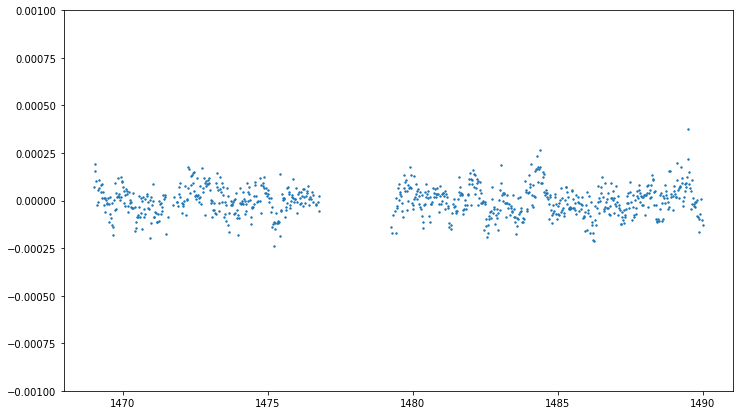

In [3]:
plt.scatter(lc['time'],normalise_flux(lc['corrected flux']),s=2)
plt.ylim(-0.001,0.001)

## Functions

In [4]:
def inject_lightcurve(time, flux, depth, injected_time, sigma, skewness):
    return flux * (
        1 - skewed_gaussian(time, depth, injected_time, sigma, skewness)
    )

def calc_shape2(m,n,time,flux,quality,real,flux_error,n_m_bg_start=3,n_m_bg_scale_factor=1):
    """Fit both symmetric and comet-like transit profiles and compare fit.

    original time: time before interpolation step

    Returns:
    (1) Asymmetry: ratio of (errors squared)
    Possible errors and return values:
    -1 : Divide by zero as comet profile is exact fit
    -2 : Too close to edge of light curve to fit profile
    -3 : Unable to fit model (e.g. timeout)
    -4 : Too much empty space in overall light curve or near dip
    -5 : Transit event too close to (before) data gap, within 1.5 days of gap.
    -6 : Transit event too close to (after) data gap, within 1 day after gap.
    (2,3) Widths of comet curve fit segments.
    info: t, x, q, fit1 and fit3 are the transit shape elements 

    Asymmetry score, 

    """
    ## how many transit widths to take the general linear trend from. start is 1/4 length of cutout from beginning, end is 1 from end.
    #first_index = n - (n_m_bg_start*n)
    #last_index = n - (n_m_bg_end*m)
    
    
    ## the transit widths of the cutout from the T-statistic minimum value. 
    ## this project requires the cutout to have more transit widths after the midtransit, to cover more of the tail.
    ## default is set to 1 transit width before and 2 transit widths after 

    n_m_bg_end = n_m_bg_scale_factor*n_m_bg_start

    cutout_before = n-(m*n_m_bg_start)
    cutout_after = n+(m*n_m_bg_end)
    
    
    if cutout_before>= 0 and cutout_after < len(time):

        t = time[cutout_before:cutout_after]
        #time_ori = original_time[cutout_before:cutout_after]

        # total time span / (cadence * length of lightcurve)
        if (t[-1]-t[0]) / (np.median(np.diff(t)) * len(t)) > 1.5:
            print(-4)
            return -4,-4,-4,-4,-4,-4,-4, -4
        
        # min time from T-statistic
        t0 = time[n]
        
        ## the time array without interpolation is used to find any data gaps from distance of data points along time axis.
        time_ori = time[real == 1]
        diffs = np.diff(time_ori)
        
        ### if a transit is less than 0.5 days within 2 days before or after transit centre, remove.
        for i,diff in enumerate(diffs):
            if diff > 0.5 and abs(t0-time_ori[i]) < 1.5: 
                print(-5)
                return -5,-5,-5,-5,-5,-5,-5,-5
            
            ### after the data gap
            if diff > 0.5 and abs(t0 - time_ori[i + 1]) < 1.5:
                print(-6)
                return -6,-6,-6,-6,-6,-6,-6,-6
            

        x = flux[cutout_before:cutout_after]
        q = quality[cutout_before:cutout_after]
        fe = flux_error[cutout_before:cutout_after]
        
        bg_before = np.mean(x[:int(m/4)])
        bg_time_before = np.mean(t[:int(m/4)])
        bg_after = np.mean(x[-int(round(m/4)):])
        bg_time_after = np.mean(t[-int(round(m/4)):])

        grad = (bg_after-bg_before)/(bg_time_after-bg_time_before)
        background_level = bg_before + grad * (t - bg_time_before)
        x = x - background_level

        try:
            params1, pcov1 = single_gaussian_curve_fit(t,-x)
            params2, pcov2 = comet_curve_fit(t,-x)
            params3, pcov3 = skewed_gaussian_curve_fit(t,-x,fe)
        except:
            return -3,-3,-3,-3,-3,-3,-3, -3

        fit1 = -gauss(t,*params1)
        fit2 = -comet_curve(t,*params2)
        fit3 = -skewed_gaussian(t,*params3)
        depth = fit3.min() # depth of comet (based on minimum point; not entirely accurate, but majority of the time true
        #min_time = t[np.argmin(x)] # time of midtransit/at minimum point

        scores = [score_fit(x,fit) for fit in [fit1,fit3]] # changed for the skewed gaussian fit
        if scores[1] > 0:
            skewness_error = np.sqrt(np.diag(pcov3)[3])
            # params3[0] is the amplitude of the gaussian...
            # params3[2] is the sigma/width of the gaussian...
            # params3[3] is the skewness...
            plt.scatter(t,x,s=2,label='data')
            plt.scatter(t,fit1,s=2,label='gauss')
            plt.scatter(t,fit2,s=2,label='comet')
            plt.scatter(t,fit3,s=2,label='skew')
            return scores[0]/scores[1], params3[0], params3[2], params3[3], skewness_error, depth, [t,x,q,fe,background_level], [fit1,fit2,fit3]
        
        else:

            return -1,-1,-1,-1,-1,-1,-1, -1
    else:     

        return -2,-2,-2,-2,-2,-2,-2, -2

In [5]:
time = lc['time']
flux = lc['corrected flux']

In [6]:
depth = 10 ** np.random.uniform(-4, -2, 1)[0]
depth

0.0007890586125076316

In [7]:
test = inject_lightcurve(time, flux, depth, 1475, 0.3, 1)

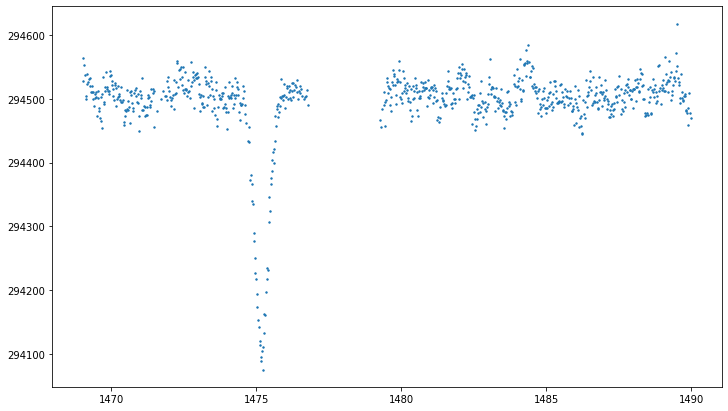

In [8]:
plt.scatter(lc['time'],test,s=2)

In [9]:
lc2 = Table([time, test, lc['quality'], lc['flux error']], names=('time', 'corrected flux', 'quality', 'flux error'))

In [10]:
test, _ = smoothing(lc2,method='median') - np.ones(len(lc2['time']))

In [11]:
lc3 = Table([time, test, lc['quality'], lc['flux error']], names=('time', 'corrected flux', 'quality', 'flux error'))

In [12]:
t, flux, quality, real, flux_error = clean_data(lc3)

In [13]:
flux *= real

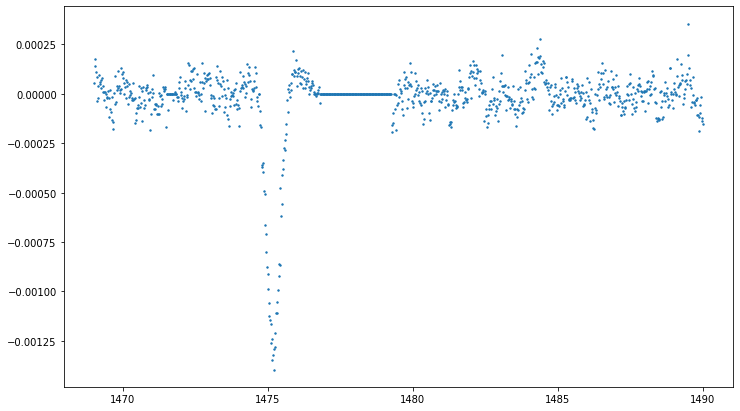

In [14]:
plt.scatter(t,flux,s=2)

In [15]:
timestep = calculate_timestep(lc)
factor = ((1/48)/timestep)
N = len(t)
ones = np.ones(N)

## fourier and Lomb-Scargle computations
A_mag = np.abs(np.fft.rfft(normalise_flux(flux)))

freq, powers = LombScargle(t,flux).autopower() # think about that one
peak_power = powers.max()

## M-statistic
M_stat = calc_mstatistic(flux)

## Perform T-statistic search method
m,n,T1,minT,minT_time,minT_duration,Tm_start,Tm_end,Tm_depth,Ts = run_test_statistic(flux, factor, timestep,t)
minT_time

1475.183020258495

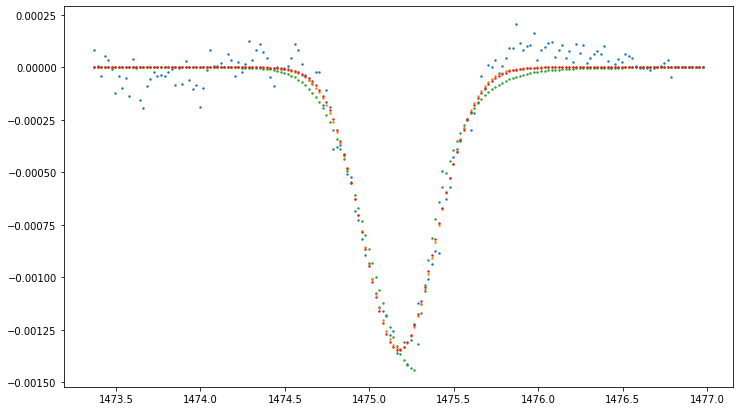

In [16]:
asym, amplitude, width, skewness, skewness_error, depth, info, fits = calc_shape2(m,n,t,flux,quality,real,flux_error)


---

## Plotting the boundaries of the different error signals

#### First: Creating different injections of same comet transit into lightcurve for consistency